# Part 3: Parameter estimation (optimization) on real data

In this notebook, we demonstrate how one can use our previous Collimator battery model and estimate it's parameters to represent a real battery for which experimental data is available. Unlike, the previous tutorial, here we will apply experimentally measured current curve and tune the parameters to the corresponding experimentally measured terminal voltage curve. We will use one set of experiments to estimate the model parameters and another set of experiments on the same battery for validation.

## Dataset

We utilise the dataset available [here](https://data.mendeley.com/datasets/cp3473x7xv/3), which tests a **3Ah LG HG2** Lithium-ion battery. In particular, we extract the dataset at 25$^\mathrm{o}$C for two experimental drive cycles:

- **Training data**: For training we use the Urban Dynamometer Driving Schedule (UDDS) drive cycle.
- **Validation**: For validation we use the Mixed cycle data, which represents a mix of UDDS, Highway Fuel Economy Test Cycle (HWFET), LA92, and US06 drive cycles.

The two files from the raw dataset are included in the `./dataset_25deg` folder.

As before, our parameters will be the $v_0(s)$, $R_s(s)$, $R_1(s)$, and $C_1(s)$ curves, represented by uniformly distributed points in the SoC interval between 0 and 1.

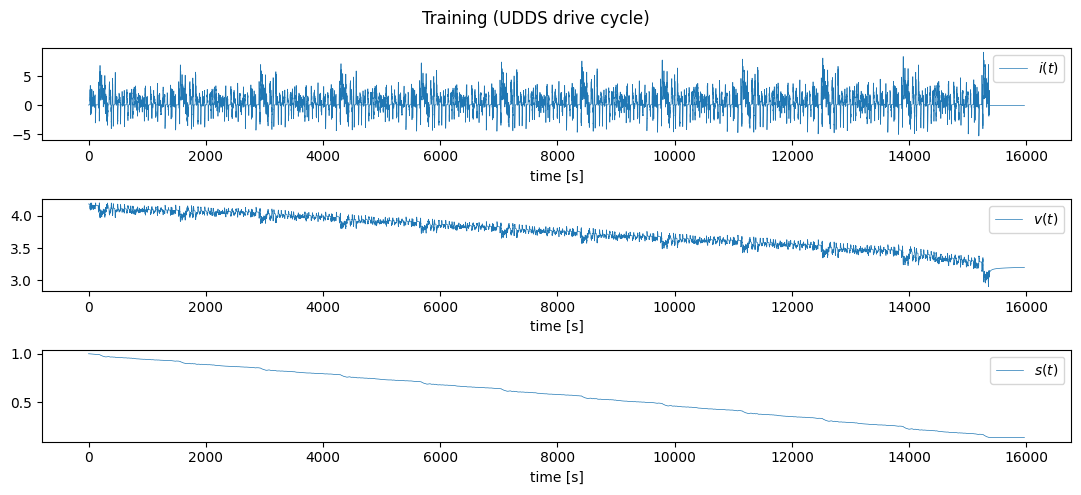

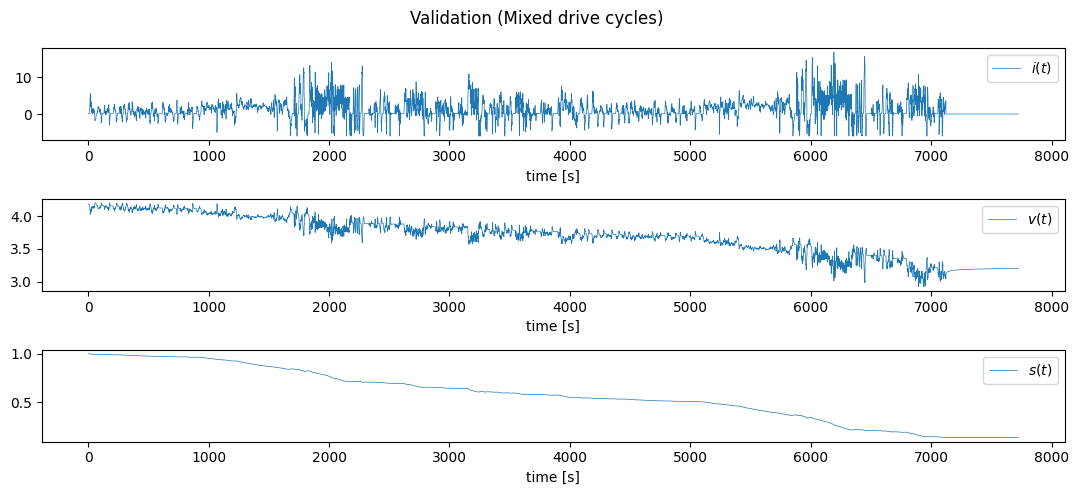

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

from jax import config

config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

from scipy.io import loadmat

train_file_name = "dataset_25deg/10-28-18_17.44 551_UDDS_25degC_LGHG2.mat"
val_file_name = "dataset_25deg/10-29-18_14.41 551_Mixed1_25degC_LGHG2.mat"

tain_data = loadmat(train_file_name)
val_data = loadmat(val_file_name)

Q = 3.0  # battery capacity is known to be 3Ah (LG HG2 cell)


def extract_features_from_matfile(filename, Q=3.0):
    data = loadmat(filename)
    t = data["meas"][0][0][0]
    vt = data["meas"][0][0][2]
    curr = -data["meas"][0][0][3]
    D = -data["meas"][0][0][4]
    soc = (Q - D) / Q
    return (
        jnp.array(t[:, 0]),
        jnp.array(vt[:, 0]),
        jnp.array(curr[:, 0]),
        jnp.array(soc[:, 0]),
    )


t_train, vt_train, curr_train, soc_train = extract_features_from_matfile(
    train_file_name
)
t_val, vt_val, curr_val, soc_val = extract_features_from_matfile(val_file_name)


def plot_exp_data(t, vt, curr, soc, title="Exp Data", lw=0.5):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(11, 5))
    ax1.plot(t, curr, label=r"$i(t)$", lw=lw)
    ax2.plot(t, vt, label=r"$v(t)$", lw=lw)
    ax3.plot(t, soc, label=r"$s(t)$", lw=lw)
    for ax in (ax1, ax2, ax3):
        ax.set_xlabel("time [s]")
        ax.legend()
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()
    return fig


fig_train = plot_exp_data(
    t_train, vt_train, curr_train, soc_train, title="Training (UDDS drive cycle)"
)
fig_val = plot_exp_data(
    t_val, vt_val, curr_val, soc_val, title="Validation (Mixed drive cycles)"
)
plt.show()

## Collimator model

Building on our previous tutorials, the only change we need to make is to replace the `Pulse` block for the discharge current with another `LookUpTable1d` block so that we can input the experimentally measured current to our battery model. Let's create a function to create this system. The only changes with respect to the previous tutorial are identified in the comments.

In [12]:
import collimator
from collimator.library import Pulse
from collimator.framework import LeafSystem

from collimator.models import Battery
from collimator.library import Adder, Power, Integrator, LookupTable1d, Clock

from collimator.simulation import SimulatorOptions, ODESolverOptions


def make_system(t_exp_data, curr_exp_data, vt_exp_data):
    def make_l2_loss(name="l2_loss"):
        builder = collimator.DiagramBuilder()

        err = builder.add(Adder(2, operators="+-", name="err"))
        sq_err = builder.add(Power(2.0, name="sq_err"))
        sq_err_int = builder.add(Integrator(0.0, name="sq_err_int"))

        builder.connect(err.output_ports[0], sq_err.input_ports[0])
        builder.connect(sq_err.output_ports[0], sq_err_int.input_ports[0])

        # Diagram level export inputs and outputs
        builder.export_input(err.input_ports[0])
        builder.export_input(err.input_ports[1])
        builder.export_output(sq_err_int.output_ports[0])

        return builder.build(name=name)

    builder = collimator.DiagramBuilder()

    discharge_current = builder.add(
        LookupTable1d(t_exp_data, curr_exp_data, "linear", name="discharge_current")
    )  # First change

    battery = builder.add(
        Battery(Q=Q, name="battery")
    )  # Battery nominal capacity is known: 3Ah.
    l2_loss = builder.add(make_l2_loss(name="l2_loss"))

    clock = builder.add(Clock(name="clock"))
    vt_exp = builder.add(
        LookupTable1d(t_exp_data, vt_exp_data, "linear", name="vt_exp")
    )

    builder.connect(
        clock.output_ports[0], discharge_current.input_ports[0]
    )  # Second change
    builder.connect(discharge_current.output_ports[0], battery.input_ports[0])
    builder.connect(clock.output_ports[0], vt_exp.input_ports[0])
    builder.connect(battery.output_ports[1], l2_loss.input_ports[0])
    builder.connect(vt_exp.output_ports[0], l2_loss.input_ports[1])

    builder.export_output(l2_loss.output_ports[0])

    diagram = builder.build()
    context = diagram.create_context()

    return (diagram, context)

We can now create the system and simulate for given $v_0(s)$, $R_s(s)$, $R_1(s)$, and $C_1(s)$ curves as below.

In [13]:
diagram, context = make_system(t_train, curr_train, vt_train)

Initialized callback discharge_current:u_0 with prereqs []
Initialized callback discharge_current:y_0 with prereqs [54]
Initialized callback battery:u_0 with prereqs []
Initialized callback battery:battery_ode with prereqs [1, 2, 8]
Initialized callback battery:y_0 with prereqs [8]
Initialized callback battery:y_1 with prereqs [8]
Initialized callback err:u_0 with prereqs []
Initialized callback err:u_1 with prereqs []
Initialized callback err:y_0 with prereqs [60, 61]
Initialized callback sq_err:u_0 with prereqs []
Initialized callback sq_err:y_0 with prereqs [63]
Initialized callback sq_err_int:in_0 with prereqs []
Initialized callback sq_err_int:sq_err_int_ode with prereqs [65]
Initialized callback sq_err_int:out_0 with prereqs [2]
Initialized callback l2_loss:err_u_0 with prereqs []
Initialized callback l2_loss:err_u_1 with prereqs []
Initialized callback l2_loss:sq_err_int_out_0 with prereqs [67]
Initialized callback clock:out_0 with prereqs [1]
Initialized callback vt_exp:u_0 wit

In [14]:
def forward_plot(
    v0_points,
    Rs_points,
    R1_points,
    C1_points,
    diagram,
    context,
    t_sim=100.0,
    t_exp=None,
    soc_exp=None,
    lw=0.5,
):
    # Update context
    new_params = {
        "v0_points": v0_points,
        "Rs_points": Rs_points,
        "R1_points": R1_points,
        "C1_points": C1_points,
    }

    subcontext = context[diagram["battery"].system_id].with_parameters(new_params)
    context = context.with_subcontext(diagram["battery"].system_id, subcontext)

    recorded_signals = {
        "vt": diagram["battery"].output_ports[1],
        "vt_exp": diagram["vt_exp"].output_ports[0],
        "soc": diagram["battery"].output_ports[0],
        "discharge_current": diagram["discharge_current"].output_ports[0],
        "l2_loss": diagram["l2_loss"].output_ports[0],
    }

    options = SimulatorOptions(
        max_major_steps=20,
    )

    sol = collimator.simulate(
        diagram,
        context,
        (0.0, t_sim),
        options=options,
        recorded_signals=recorded_signals,
    )
    l2_loss_final = sol.outputs["l2_loss"][-1]
    print(f"{l2_loss_final=}")

    fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(11, 8))
    fig.tight_layout()
    ax0.plot(
        sol.time,
        sol.outputs["discharge_current"],
        "-b",
        label="Discharge current: exp/sim",
        lw=lw,
    )
    ax1.plot(sol.time, sol.outputs["vt"], "-b", label="Terminal voltage: sim", lw=lw)
    ax1.plot(
        sol.time, sol.outputs["vt_exp"], "-r", label="Terminal voltage: exp", lw=lw
    )
    ax2.plot(sol.time, sol.outputs["soc"], "-b", label="SoC: sim", lw=lw)
    if (t_exp is not None) and (soc_exp is not None):
        ax2.plot(t_exp, soc_exp, "-r", label="SoC: exp", lw=lw)
    ax3.plot(sol.time, sol.outputs["l2_loss"], label=r"$\int e^2 dt$", lw=lw)
    ax0.legend()
    ax1.legend()
    ax2.legend()
    ax3.legend()
    fig.tight_layout()

    return fig

l2_loss_final=2095.2384057892014


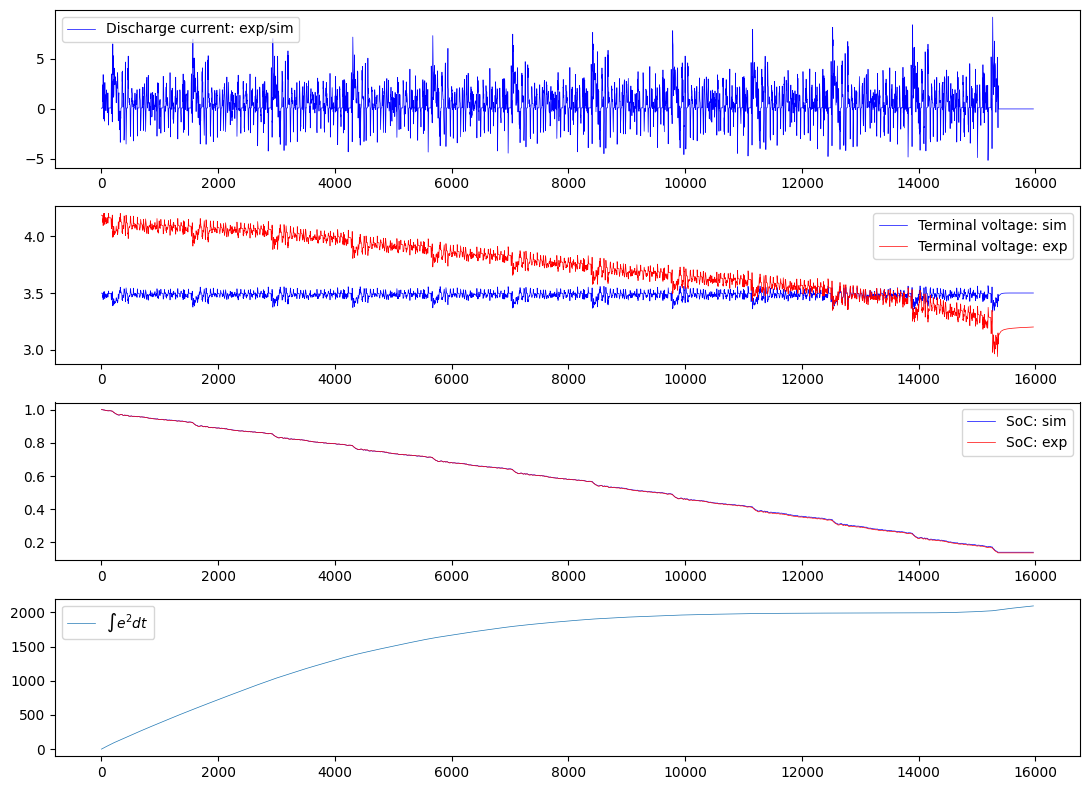

In [15]:
fig_forward = forward_plot(
    v0_points=3.5 * jnp.ones(11),
    Rs_points=15e-03 * jnp.ones(11),
    R1_points=15e-03 * jnp.ones(11),
    C1_points=2e03 * jnp.ones(11),
    diagram=diagram,
    context=context,
    t_sim=t_train[-1],
    t_exp=t_train,
    soc_exp=soc_train,
)
plt.show()

We see that for our chosen $v_0(s)$, $R_s(s)$, $R_1(s)$, and $C_1(s)$ curves, there is a large discrepancy between the experimental and simulated curves. Let's perform optimization using `optax` to estimate the $v_0(s)$, $R_s(s)$, $R_1(s)$, and $C_1(s)$ curves.

### Optimization with `optax`

As before we create an efficient jit-compiled `forward` function to only return the final $L_2$ error and not record any signals. We also use the previous parameter transformation trick to work with unconstrained optimizers.

In [16]:
# Set reference values for parameter transformation
v0_ref = 3.0
Rs_ref = 15e-03
R1_ref = 15e-03
C1_ref = 3e03

T_train = t_train[-1]


@jax.jit
def forward(log_params, context):
    # transform the log_params to real parametric space and update context

    params = jnp.exp(log_params)
    params_arr = params.reshape((4, 11))

    new_params = {
        "v0_points": v0_ref * params_arr[0, :],
        "Rs_points": Rs_ref * params_arr[1, :],
        "R1_points": R1_ref * params_arr[2, :],
        "C1_points": C1_ref * params_arr[3, :],
    }

    subcontext = context[diagram["battery"].system_id].with_parameters(new_params)
    context = context.with_subcontext(diagram["battery"].system_id, subcontext)

    solver = "Tsit5"
    options = SimulatorOptions(
        enable_autodiff=True, max_major_steps=20,
    )

    sol = collimator.simulate(diagram, context, (0.0, T_train), options=options)

    l2_loss = sol.context[diagram["l2_loss"]["sq_err_int"].system_id].continuous_state

    # normalise the l2_loss and add regularisation (optional)
    cost = (1.0 / T_train) * l2_loss  # + (1.0/44)*1e-03*jnp.sum(log_params**2)
    return cost

Next, we can choose an initial value and use the automatically computed gradient functions by `jax` to perform the optimization.

In [17]:
# For some set of parameters (also initial guesses represented by `_0` suffix) run the simulation and print cost
v0_points_0 = 3.5 * jnp.ones(11)
Rs_points_0 = 15e-03 * jnp.ones(11)
R1_points_0 = 15e-03 * jnp.ones(11)
C1_points_0 = 2e03 * jnp.ones(11)

log_params_0 = jnp.hstack(
    [
        jnp.log(v0_points_0 / v0_ref),
        jnp.log(Rs_points_0 / Rs_ref),
        jnp.log(R1_points_0 / R1_ref),
        jnp.log(C1_points_0 / C1_ref),
    ]
)
cost = forward(log_params_0, context)
print(f"{cost=}")

grad_forward = jax.jit(jax.grad(forward))
grads_0 = grad_forward(log_params_0, context)
print(f"{grads_0.shape}")

cost=Array(0.13123458, dtype=float64)
(44,)


In [18]:
import optax

# Optax optimizer
optimizer = optax.adam(learning_rate=0.01)

# Initialize optimizer state
log_params = log_params_0
opt_state = optimizer.init(log_params)

# Gradient descent loop
num_epochs = 1000
for epoch in range(num_epochs):
    gradients = grad_forward(log_params, context)
    updates, opt_state = optimizer.update(gradients, opt_state)
    log_params = optax.apply_updates(log_params, updates)

    if (epoch + 1) % 50 == 0:
        current_loss_value = forward(log_params, context)
        print(
            f"Epoch [{epoch+1}/{num_epochs}]: forward(log_params) = {current_loss_value}"
        )

Epoch [50/1000]: forward(log_params) = 0.00048530035728413975
Epoch [100/1000]: forward(log_params) = 9.472438526977075e-05
Epoch [150/1000]: forward(log_params) = 6.144828582829977e-05
Epoch [200/1000]: forward(log_params) = 5.801894401488122e-05
Epoch [250/1000]: forward(log_params) = 6.389433861809318e-05
Epoch [300/1000]: forward(log_params) = 7.378804424155042e-05
Epoch [350/1000]: forward(log_params) = 8.502881369270044e-05
Epoch [400/1000]: forward(log_params) = 6.805419759874207e-05
Epoch [450/1000]: forward(log_params) = 7.119918086193503e-05
Epoch [500/1000]: forward(log_params) = 4.994770852930352e-05
Epoch [550/1000]: forward(log_params) = 5.314480434836416e-05
Epoch [600/1000]: forward(log_params) = 5.188556274816763e-05
Epoch [650/1000]: forward(log_params) = 4.8152906659936536e-05
Epoch [700/1000]: forward(log_params) = 6.464870420540385e-05
Epoch [750/1000]: forward(log_params) = 6.460517621065884e-05
Epoch [800/1000]: forward(log_params) = 5.301947197340285e-05
Epoch [

We can now re-perform the simulation with the optimal parameters and see the results against the experimental data.

l2_loss_final=1.155780428897616


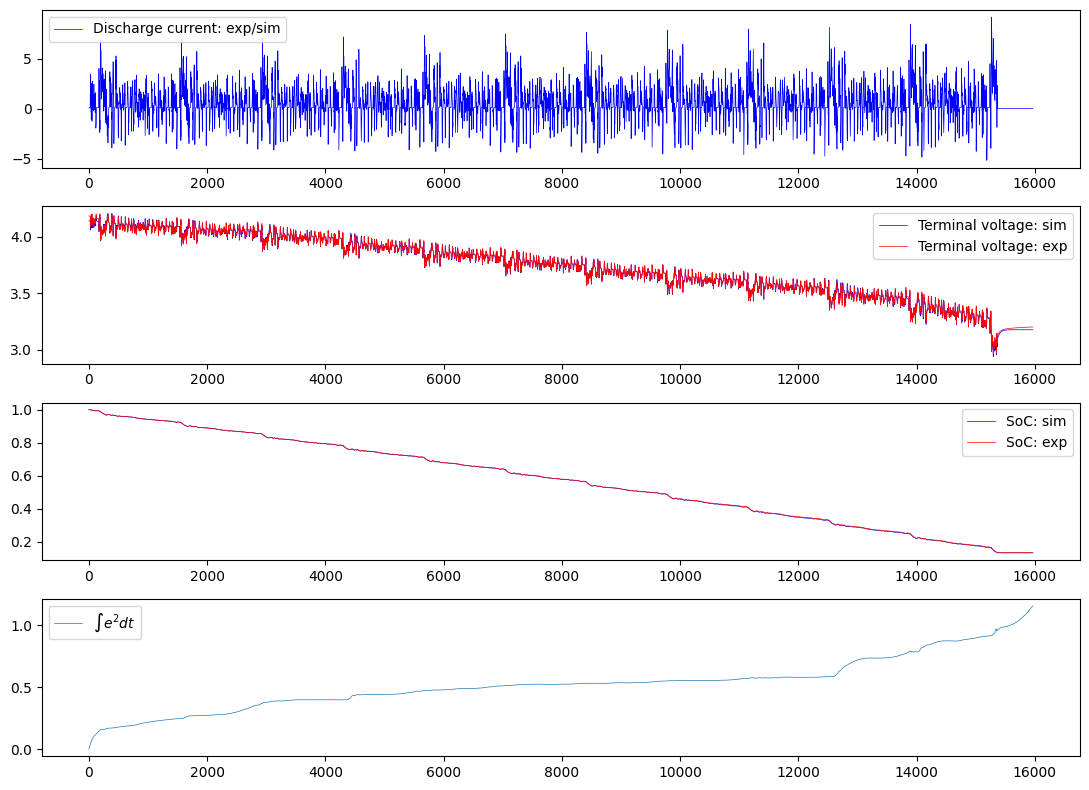

In [19]:
opt_log_params = log_params

# Convert from \psi-space to real space
opt_params = jnp.exp(opt_log_params)
opt_params_arr = opt_params.reshape((4, 11))
opt_v0_points = v0_ref * opt_params_arr[0, :]
opt_Rs_points = Rs_ref * opt_params_arr[1, :]
opt_R1_points = R1_ref * opt_params_arr[2, :]
opt_C1_points = C1_ref * opt_params_arr[3, :]

fig_forward = forward_plot(
    v0_points=opt_v0_points,
    Rs_points=opt_Rs_points,
    R1_points=opt_R1_points,
    C1_points=opt_C1_points,
    context=context,
    diagram=diagram,
    t_sim=t_train[-1],
    t_exp=t_train,
    soc_exp=soc_train,
)
plt.show()

We find an excellent agreement between the experimental and simulated data with the optimal parameters. To obtain further confidence in the estimated model, we can run the simulation on unseen data, i.e. the validation data, and see how the model's predictions compare with experimentally measured data.

Initialized callback discharge_current:u_0 with prereqs []
Initialized callback discharge_current:y_0 with prereqs [75]
Initialized callback battery:u_0 with prereqs []
Initialized callback battery:battery_ode with prereqs [1, 2, 8]
Initialized callback battery:y_0 with prereqs [8]
Initialized callback battery:y_1 with prereqs [8]
Initialized callback err:u_0 with prereqs []
Initialized callback err:u_1 with prereqs []
Initialized callback err:y_0 with prereqs [81, 82]
Initialized callback sq_err:u_0 with prereqs []
Initialized callback sq_err:y_0 with prereqs [84]
Initialized callback sq_err_int:in_0 with prereqs []
Initialized callback sq_err_int:sq_err_int_ode with prereqs [86]
Initialized callback sq_err_int:out_0 with prereqs [2]
Initialized callback l2_loss:err_u_0 with prereqs []
Initialized callback l2_loss:err_u_1 with prereqs []
Initialized callback l2_loss:sq_err_int_out_0 with prereqs [88]
Initialized callback clock:out_0 with prereqs [1]
Initialized callback vt_exp:u_0 wit

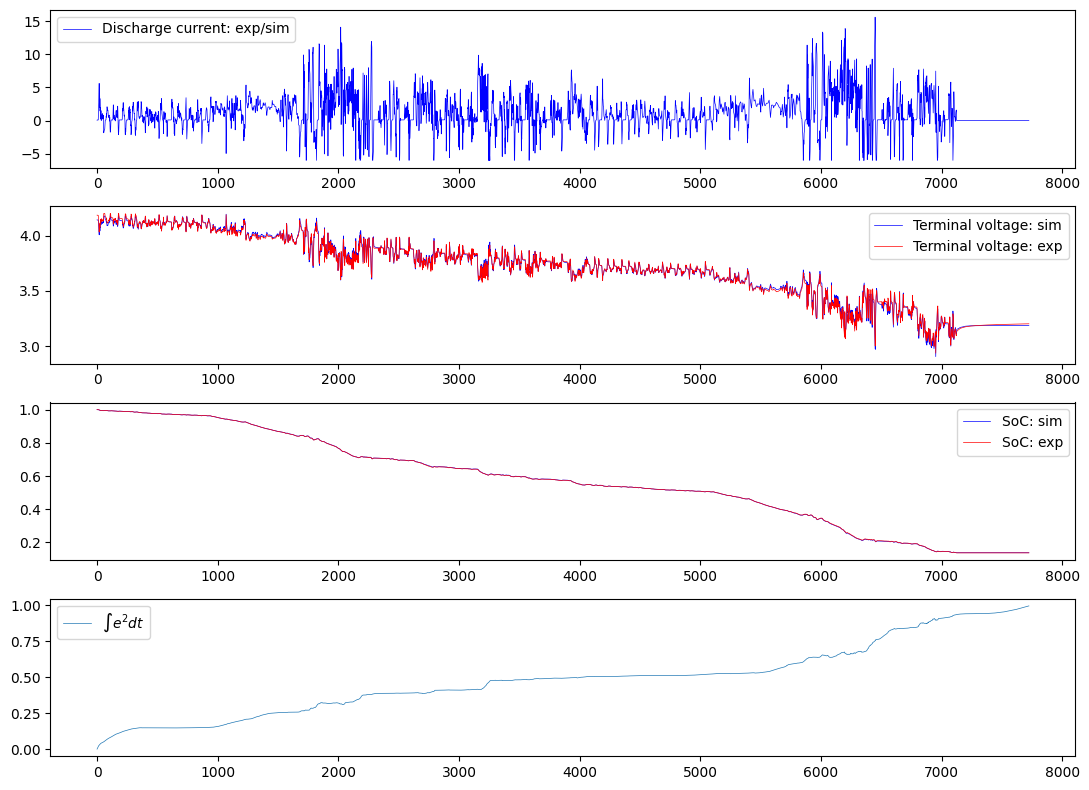

In [20]:
diagram_val, context_val = make_system(t_val, curr_val, vt_val)

fig_forward = forward_plot(
    v0_points=opt_v0_points,
    Rs_points=opt_Rs_points,
    R1_points=opt_R1_points,
    C1_points=opt_C1_points,
    diagram=diagram_val,
    context=context_val,
    t_sim=t_val[-1],
    t_exp=t_val,
    soc_exp=soc_val,
)
plt.show()

Again, we find excellent agreement between the model and the experiments, giving us additional confidence that the estimated model is good.